In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time

In [2]:
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name, end=' ')
        print('Elapsed: %s' % (time.time() - self.tstart))

In [3]:
from tang_jcompneuro_legacy import glm, glm_matlab, glm_matlab_aux

/home/yimengzh_everyday/miniconda2/envs/tf15/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/home/yimengzh_everyday/miniconda2/envs/tf15/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: foreach

  warnings.warn(x, RRuntimeWarning)
/home/yimengzh_everyday/miniconda2/envs/tf15/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loaded glmnet 2.0-13


  warnings.warn(x, RRuntimeWarning)


In [4]:
# # use MATLAB example.
# rng_state = np.random.RandomState(seed=0)
# X = rng_state.randn(1000,20)
# coef = np.zeros(20)
# coef[[4, 9, 14]] = np.array([.4, .2, .3])
# bias = 1
# y_linear = X@coef + bias
# foldid = glm_matlab.convert_sklearn_kfold_to_glmnet_foldid(1000, 5, seed=0)

In [5]:
# dummy data
# use MATLAB example.
rng_state = np.random.RandomState(seed=0)
X_train_pca = rng_state.randn(1000,5)
coef = np.zeros(5)
coef[[1, 3, 4]] = np.array([.4, .2, .3])
bias = 1
y_linear = X_train_pca@coef + bias
y_linear = y_linear[:,np.newaxis]
y_linear = np.log(np.exp(y_linear) + 1)
foldid = glm_matlab.convert_sklearn_kfold_to_glmnet_foldid(1000, 5, seed=0)

In [6]:
# first, do Gaussian.
def test_gaussian(X, y):
    with Timer('Gaussian R'):
        fit_R = glm.glmnet_cv(X, y, standardize=False, type_measure='mse',
                            family='gaussian',
                            foldid=foldid, alpha=1.0, keep=True)
        predicted_y_R = glm.glmnet_extract_preval(fit_R, 'lambda.min')
#     print(np.array(fit_R.rx2('lambda')), predicted_y_R.shape)
    
    # then let's use default value of matlab
    with Timer('Gaussian MATLAB'):
        predicted_y_matlab, fit_matlab = glm_matlab.glmnet_cv_best_result(X,y,standardize=False,
                            family='gaussian',foldid=foldid, alpha=1.0, debug=True)
#     print(fit_matlab['FitInfo']['Lambda'], predicted_y_matlab.shape)
#     predicted_y_R, predicted_y_matlab
    with Timer('Gaussian MATLAB lambda seq'):
        lambda_seq = glm_matlab.glmnet_lambda_sequence(X,y,standardize=False,
                            family='gaussian', alpha=1.0)
    
    # check their lambda
    print(np.array(fit_R.rx2('lambda')),
          fit_matlab['FitInfo']['Lambda'][0,0].ravel()[::-1])
    lam_size = min(fit_matlab['FitInfo']['Lambda'][0,0].ravel().size, lambda_seq.size)
    #print(fit_matlab['FitInfo']['Lambda'][0,0].ravel()[::-1][:lam_size]-lambda_seq[::-1][:lam_size])
    # it's not equal, because in glmfitting, total weight is multiplied then divided.
    assert np.allclose(fit_matlab['FitInfo']['Lambda'][0,0].ravel()[::-1][:lam_size],
                          lambda_seq[::-1][:lam_size])
    
    # check their deviance
    print(np.array(fit_R.rx2('cvm')),
          fit_matlab['FitInfo']['Deviance'][0,0].ravel()[::-1]/1000)
    
    
    plt.close()
    plt.figure()
    plt.scatter(predicted_y_R, predicted_y_matlab)
    plt.title(f'{pearsonr(predicted_y_R, predicted_y_matlab)[0]}')
    plt.axis('equal')
    plt.plot([-1,3],[-1,3])
    plt.show()
    
    
    plt.close()
    plt.figure()
    plt.scatter(y, predicted_y_matlab)
    plt.title(f'{pearsonr(y.ravel(), predicted_y_matlab)[0]}')
    plt.axis('equal')
    plt.plot([0,3],[0,3])
    plt.show()
    return predicted_y_R, predicted_y_matlab

[Gaussian R] Elapsed: 0.8467562198638916
[Gaussian MATLAB] Elapsed: 10.790034055709839
[Gaussian MATLAB lambda seq] Elapsed: 9.88962197303772
[ 0.25636076  0.23358638  0.21283521  0.19392752  0.17669953  0.16100203
  0.14669905  0.13366672  0.12179213  0.11097246  0.10111397  0.09213128
  0.08394659  0.07648901  0.06969394  0.06350252  0.05786113  0.05272091
  0.04803733  0.04376982  0.03988143  0.03633848  0.03311027  0.03016884
  0.02748872  0.0250467   0.02282162  0.02079421  0.01894691  0.01726372
  0.01573006  0.01433264  0.01305937  0.01189921  0.01084212  0.00987894
  0.00900132  0.00820167  0.00747305  0.00680917  0.00620426  0.00565309
  0.00515089  0.00469329  0.00427636  0.00389646  0.00355031  0.00323491
  0.00294753  0.00268568  0.00244709  0.0022297   0.00203162  0.00185113
  0.00168668  0.00153684] [  2.56360765e-01   2.33586381e-01   2.12835211e-01   1.93927517e-01
   1.76699531e-01   1.61002032e-01   1.46699055e-01   1.33666715e-01
   1.21792133e-01   1.10972455e-01   

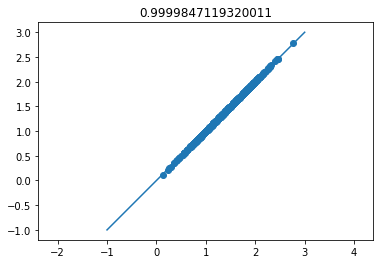

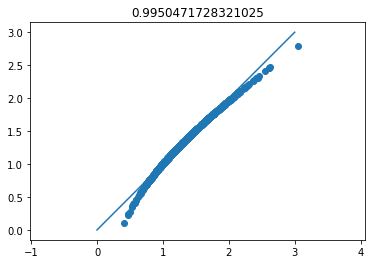

In [7]:
y_R, y_matlab = test_gaussian(X_train_pca, y_linear)

In [8]:
# first, do Gaussian.
def test_softplus(X, y):
    with Timer('Gaussian R'):
        fit_R = glm.glmnet_cv(X, y, standardize=False, type_measure='mse',
                            family='gaussian',
                            foldid=foldid, alpha=1.0, keep=True)
        predicted_y_R = glm.glmnet_extract_preval(fit_R, 'lambda.min')
#     print(np.array(fit_R.rx2('lambda')), predicted_y_R.shape)
    
    # then let's use default value of matlab
    with Timer('softplus MATLAB'):
        predicted_y_matlab, fit_matlab = glm_matlab.glmnet_cv_best_result(X,y,standardize=False,
                            family='softplus',foldid=foldid, alpha=1.0, debug=True)
#     print(fit_matlab['FitInfo']['Lambda'], predicted_y_matlab.shape)
#     predicted_y_R, predicted_y_matlab
    with Timer('softplus MATLAB lambda seq'):
        lambda_seq = glm_matlab.glmnet_lambda_sequence(X,y,standardize=False,
                        family='softplus', alpha=1.0)
    
    # check their lambda
    print(np.array(fit_R.rx2('lambda')),
          fit_matlab['FitInfo']['Lambda'][0,0].ravel()[::-1])
    lam_size = min(fit_matlab['FitInfo']['Lambda'][0,0].ravel().size, lambda_seq.size)
    assert np.allclose(fit_matlab['FitInfo']['Lambda'][0,0].ravel()[::-1][:lam_size],
                         lambda_seq[::-1][:lam_size])
    # check their deviance
    print(np.array(fit_R.rx2('cvm')),
          fit_matlab['FitInfo']['Deviance'][0,0].ravel()[::-1]/1000)
    
    plt.close()
    plt.figure()
    plt.scatter(predicted_y_R, predicted_y_matlab)
    plt.title(f'{pearsonr(predicted_y_R, predicted_y_matlab)[0]}')
    plt.axis('equal')
    plt.plot([-1,3],[-1,3])
    plt.show()
    
    
    plt.close()
    plt.figure()
    plt.scatter(y, predicted_y_matlab)
    plt.title(f'{pearsonr(y.ravel(), predicted_y_matlab)[0]}')
    plt.axis('equal')
    plt.plot([0,3],[0,3])
    plt.show()
    return predicted_y_R, predicted_y_matlab

[Gaussian R] Elapsed: 0.7663099765777588
[softplus MATLAB] Elapsed: 10.620922803878784
[softplus MATLAB lambda seq] Elapsed: 9.412582635879517
[ 0.25636076  0.23358638  0.21283521  0.19392752  0.17669953  0.16100203
  0.14669905  0.13366672  0.12179213  0.11097246  0.10111397  0.09213128
  0.08394659  0.07648901  0.06969394  0.06350252  0.05786113  0.05272091
  0.04803733  0.04376982  0.03988143  0.03633848  0.03311027  0.03016884
  0.02748872  0.0250467   0.02282162  0.02079421  0.01894691  0.01726372
  0.01573006  0.01433264  0.01305937  0.01189921  0.01084212  0.00987894
  0.00900132  0.00820167  0.00747305  0.00680917  0.00620426  0.00565309
  0.00515089  0.00469329  0.00427636  0.00389646  0.00355031  0.00323491
  0.00294753  0.00268568  0.00244709  0.0022297   0.00203162  0.00185113
  0.00168668  0.00153684] [ 0.18958874  0.1727462   0.1573999   0.14341693  0.13067616  0.11906725
  0.10848965  0.09885173  0.09007001  0.08206844  0.07477771  0.06813466
  0.06208176  0.05656659  0.

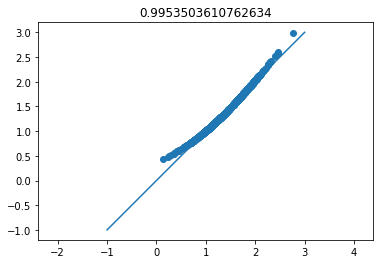

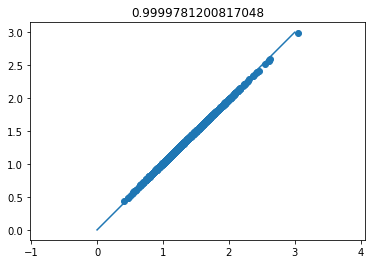

In [9]:
y_R, y_matlab = test_softplus(X_train_pca, y_linear)

In [10]:
# first, do Gaussian.
def test_poisson(X, y):
    with Timer('poisson R'):
        fit_R = glm.glmnet_cv(X, y, standardize=False, type_measure='deviance',
                            family='poisson',
                            foldid=foldid, alpha=1.0, keep=True)
        predicted_y_R = glm.glmnet_extract_preval(fit_R, 'lambda.min')
#     print(np.array(fit_R.rx2('lambda')), predicted_y_R.shape)
    
    # then let's use default value of matlab
    with Timer('poisson MATLAB'):
        predicted_y_matlab, fit_matlab = glm_matlab.glmnet_cv_best_result(X,y,standardize=False,
                            family='poisson',foldid=foldid, alpha=1.0, debug=True)
#     print(fit_matlab['FitInfo']['Lambda'], predicted_y_matlab.shape)
#     predicted_y_R, predicted_y_matlab
    with Timer('poisson MATLAB lambda seq'):
        lambda_seq = glm_matlab.glmnet_lambda_sequence(X,y,standardize=False,
                        family='poisson', alpha=1.0)
    
    # check their lambda
    print(np.array(fit_R.rx2('lambda')),
          fit_matlab['FitInfo']['Lambda'][0,0].ravel()[::-1])
    lam_size = min(fit_matlab['FitInfo']['Lambda'][0,0].ravel().size, lambda_seq.size)
    assert np.allclose(fit_matlab['FitInfo']['Lambda'][0,0].ravel()[::-1][:lam_size],
                         lambda_seq[::-1][:lam_size])
    # check their deviance
    print(np.array(fit_R.rx2('cvm')),
          fit_matlab['FitInfo']['Deviance'][0,0].ravel()[::-1]/1000)
    
    plt.close()
    plt.figure()
    plt.scatter(np.exp(predicted_y_R), predicted_y_matlab)
    plt.title(f'{pearsonr(np.exp(predicted_y_R), predicted_y_matlab)[0]}')
    plt.axis('equal')
    plt.plot([-1,3],[-1,3])
    plt.show()
    
    
    plt.close()
    plt.figure()
    plt.scatter(y, predicted_y_matlab)
    plt.title(f'{pearsonr(y.ravel(), predicted_y_matlab)[0]}')
    plt.axis('equal')
    plt.plot([0,3],[0,3])
    plt.show()
    return predicted_y_R, predicted_y_matlab

[poisson R] Elapsed: 0.2905845642089844
[poisson MATLAB] Elapsed: 10.765320062637329
[poisson MATLAB lambda seq] Elapsed: 10.231109380722046
[ 0.25636076  0.23358638  0.21283521  0.19392752  0.17669953  0.16100203
  0.14669905  0.13366672  0.12179213  0.11097246  0.10111397  0.09213128
  0.08394659  0.07648901  0.06969394  0.06350252  0.05786113  0.05272091
  0.04803733  0.04376982  0.03988143  0.03633848  0.03311027  0.03016884
  0.02748872  0.0250467   0.02282162  0.02079421  0.01894691  0.01726372
  0.01573006  0.01433264  0.01305937  0.01189921  0.01084212  0.00987894
  0.00900132  0.00820167  0.00747305  0.00680917  0.00620426  0.00565309
  0.00515089  0.00469329  0.00427636  0.00389646  0.00355031  0.00323491
  0.00294753  0.00268568  0.00244709  0.0022297   0.00203162] [  2.56360765e-01   2.33586381e-01   2.12835211e-01   1.93927517e-01
   1.76699531e-01   1.61002032e-01   1.46699055e-01   1.33666715e-01
   1.21792133e-01   1.10972455e-01   1.01113968e-01   9.21312819e-02
   8.3

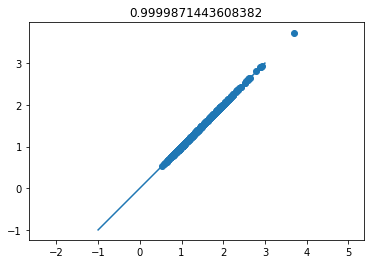

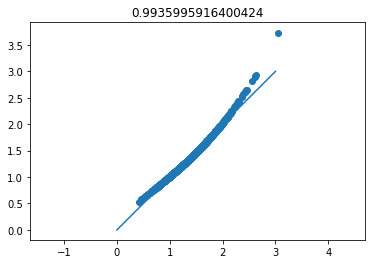

In [11]:
y_R, y_matlab = test_poisson(X_train_pca, y_linear)